In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Generate New Text

- ก่อนหน้านี้ลองทำ classification text ไปแล้ว
- generate ?
- คิดว่ามันเป็น prediction (คำต่อไป)

ข้อมูลสำหรับ train

```text
twinkle twinkle little star
```

เมื่อต้องการ predict คำต่อไป

```test
twinkle twinkle little ...?
```

NN จะรู้ว่าคำต่อไปคือ `star`


ถ้าให้ **corpus** แล้ว NN train กับ แต่ละประโยคใน corpus
จะสามารถทำ text generation ได้

In [2]:
with open("./data/ashes.txt", "r", encoding="utf-8") as f:
    corpus = [line for line in f.readlines() if line != '\n']

In [3]:
corpus

['I could hear the signs calling out from the bottom of the fire\n',
 'I am like a torch flickering in the wind as the saying goes\n',
 'Lost all my precious\n',
 'Rage ate me up\n',
 'Endless forlornness has made me numb\n',
 "I'd rather rise from here\n",
 'Or should I hold on to my past?\n',
 'They’ve burnt to ashes\n',
 'Faded to grey\n',
 'Returned to the earth\n',
 "Yes it's meant to be\n",
 'Uncertain flame of hope I found\n',
 'Will you lead me back on the right track?']

In [4]:
# config

num_words = 200
oov_token = '<OOV>'

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, 
                                                  oov_token=oov_token)
tokenizer.fit_on_texts(corpus)

In [6]:
word_index = tokenizer.word_index

for k in list(word_index.keys())[:10]:
    print(f"{k}:\t{word_index[k]}")
    
index_word = {i: w for w, i in word_index.items()}

<OOV>:	1
the:	2
to:	3
i:	4
me:	5
from:	6
of:	7
my:	8
on:	9
could:	10


In [7]:
# total word in vocab, include oov
len(tokenizer.word_index)

66

In [8]:
sequences = tokenizer.texts_to_sequences(corpus)

In [9]:
sequences[:3]

[[4, 10, 11, 2, 12, 13, 14, 6, 2, 15, 7, 2, 16],
 [4, 17, 18, 19, 20, 21, 22, 2, 23, 24, 2, 25, 26],
 [27, 28, 8, 29]]

# n-gram

In [10]:
input_sequences = []
for sequence in sequences:
    for i in range(1, len(sequence)):
        n_gram_seq = sequence[:i+1]
        input_sequences.append(n_gram_seq)

In [11]:
input_sequences[:10]

[[4, 10],
 [4, 10, 11],
 [4, 10, 11, 2],
 [4, 10, 11, 2, 12],
 [4, 10, 11, 2, 12, 13],
 [4, 10, 11, 2, 12, 13, 14],
 [4, 10, 11, 2, 12, 13, 14, 6],
 [4, 10, 11, 2, 12, 13, 14, 6, 2],
 [4, 10, 11, 2, 12, 13, 14, 6, 2, 15],
 [4, 10, 11, 2, 12, 13, 14, 6, 2, 15, 7]]

In [12]:
max_length = max([len(seq) for seq in input_sequences])

In [13]:
padded_input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='pre')

In [14]:
padded_input_sequences[:3]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 10, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 10, 11,  2]])

In [15]:
x = padded_input_sequences[:, :-1]
y = padded_input_sequences[:, -1:]

In [16]:
y_onehot = tf.keras.utils.to_categorical(y, num_classes=num_words)

In [17]:
y_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Model

In [18]:
embedding_dims = 32
num_epochs = 1500

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dims, input_length=max_length-1),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(num_words, activation='softmax')
])

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [21]:
model.compile(optimizer=optimizer, 
              metrics=['accuracy'], loss='categorical_crossentropy')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 32)            6400      
_________________________________________________________________
lstm (LSTM)                  (None, 20)                4240      
_________________________________________________________________
dense (Dense)                (None, 200)               4200      
Total params: 14,840
Trainable params: 14,840
Non-trainable params: 0
_________________________________________________________________


In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if (epoch+1) % 250 == 0:
            print(f"End epoch {epoch+1} of training;\n\tloss: {logs['loss']}, accuracy: {logs['accuracy']}")

In [24]:
hist = model.fit(x, y_onehot, epochs=num_epochs, verbose=0, callbacks=[CustomCallback()])

End epoch 250 of training;
	loss: 0.34464094042778015, accuracy: 0.8873239159584045
End epoch 500 of training;
	loss: 0.16501201689243317, accuracy: 0.9436619877815247
End epoch 750 of training;
	loss: 0.08032507449388504, accuracy: 0.9577465057373047
End epoch 1000 of training;
	loss: 0.05213554576039314, accuracy: 0.9718309640884399
End epoch 1250 of training;
	loss: 0.026708466932177544, accuracy: 0.98591548204422
End epoch 1500 of training;
	loss: 0.023481542244553566, accuracy: 0.98591548204422


c:\users\chuan\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


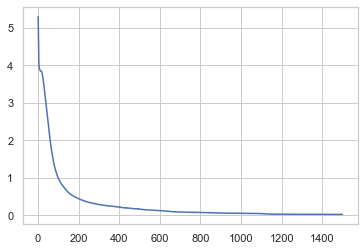

In [25]:
epochs = np.arange(num_epochs)
sns.lineplot(epochs, hist.history['loss'])
plt.show()

c:\users\chuan\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


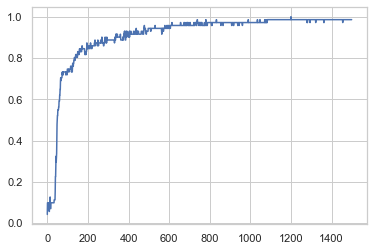

In [26]:
epochs = np.arange(num_epochs)
sns.lineplot(epochs, hist.history['accuracy'])
plt.show()

## มีคำซ้ำในการ predict

ใช้ bidirectional LSTM แก้ปัญหาได้(บ้าง)

## ไหน ลอง predict ดิ้

In [28]:
text = "I could hear the signs calling out from the bottom of the fire"

In [29]:
tokenized_text = tokenizer.texts_to_sequences([text])[0]
tokenized_text

[4, 10, 11, 2, 12, 13, 14, 6, 2, 15, 7, 2, 16]

In [30]:
first_n_word = 5
padded_tokenized_text = pad_sequences([tokenized_text[:first_n_word]], padding='pre', maxlen=max_length)

In [31]:
padded_tokenized_text

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  4, 10, 11,  2, 12]])

In [42]:
predicted = model.predict(padded_tokenized_text)
predicted_index = np.argmax(predicted)
predicted_word = index_word[predicted_index]

In [49]:
input_text = []
for token in padded_tokenized_text[0][-first_n_word:]:
    input_text.append(index_word[token])

print(f"{' '.join(input_text)} | {predicted_word}")

i could hear the signs | calling


In [48]:
print(text)

I could hear the signs calling out from the bottom of the fire


In [50]:
tokenized_text

[4, 10, 11, 2, 12, 13, 14, 6, 2, 15, 7, 2, 16]

In [60]:
predict_next_n = 5
first_n = 5
input_text = tokenized_text[:first_n]
predicted_words = []

for i in range(predict_next_n):
    padded_tokenized_text = pad_sequences([input_text], padding='pre', maxlen=max_length)    
    predicted = model.predict(padded_tokenized_text)
    predicted_index = np.argmax(predicted)
    predicted_words.append(predicted_index)
    input_text.append(predicted_index)

In [64]:
x = ' '.join([index_word[token] for token in input_text[:first_n]])
y = ' '.join([index_word[token] for token in predicted_words])

In [68]:
print(f"{x} | {y}")


print("original text:")
print(text)

i could hear the signs | calling out from the bottom
original text:
I could hear the signs calling out from the bottom of the fire


## ลอง predict หลายๆ คำ

In [69]:
predict_next_n = 15
first_n = 5
input_text = tokenized_text[:first_n]
predicted_words = []

for i in range(predict_next_n):
    padded_tokenized_text = pad_sequences([input_text], padding='pre', maxlen=max_length)    
    predicted = model.predict(padded_tokenized_text)
    predicted_index = np.argmax(predicted)
    predicted_words.append(predicted_index)
    input_text.append(predicted_index)

In [70]:
x = ' '.join([index_word[token] for token in input_text[:first_n]])
y = ' '.join([index_word[token] for token in predicted_words])

In [72]:
print(f"{x} | {y}")

i could hear the signs | calling out from the bottom of the fire rather rise from the bottom of the
